# Exercise: Insights

- A Studio that produces movies asked us whether we could provide valuable (for them) insights based on our data.

- Also, our procurement team, ie the team that signs new studios and new films, asked us whether we could help them make data-driven decisions on what films to sign next.

In [164]:
import re
from datetime import datetime
import numpy as np
import pandas as pd
import dask.dataframe as dd

# visualization imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable
from wordcloud import WordCloud

%matplotlib inline

In [113]:
# upload datasets

movies_df = pd.read_csv("/Users/cesareressa/Documents/datasets/movies.csv")
ratings_df = pd.read_csv("/Users/cesareressa/Documents/datasets/ratings.csv")
tags_df = pd.read_csv("/Users/cesareressa/Documents/datasets/tags.csv")

Exploratory Analysis

In [114]:
number_of_movies = len(movies_df.movieId.unique())

movies_with_ratings = len(ratings_df.movieId.unique())

movies_with_tags = len(tags_df.movieId.unique())

percent_movies_with_ratings = (movies_with_ratings / number_of_movies) * 100
percent_movies_with_ratings = round(percent_movies_with_ratings, 2)
percent_movies_with_tags = (movies_with_tags / number_of_movies) * 100
percent_movies_with_tags = round(percent_movies_with_tags, 2)

print(f"Total number of movies is: {number_of_movies}.")
print("\n")
print(f"Movies with ratings are: {movies_with_ratings}, or {percent_movies_with_ratings}% of total number of movies.")
print("\n")
print(f"Movies with tags are: {movies_with_tags}, or {percent_movies_with_tags}% of total number of movies.")


Total number of movies is: 58098.


Movies with ratings are: 53889, or 92.76% of total number of movies.


Movies with tags are: 45981, or 79.14% of total number of movies.


Transform datasets 

In [115]:
# add movie year column and convert it
movies_df["movie_year"] = movies_df.title.str.extract(r"\((\d{4})\)(?!.*\(\d{4}\))")
movies_df["movie_year"] = pd.to_numeric(movies_df.movie_year, downcast="integer", errors="coerce")

# split genres
movies_df["genres"] = movies_df["genres"].str.split("|")



In [116]:
# create dask dataframes
dd_movies = dd.read_csv("/Users/cesareressa/Documents/datasets/movies.csv")
dd_ratings = dd.read_csv("/Users/cesareressa/Documents/datasets/ratings.csv")
dd_tags = dd.read_csv("/Users/cesareressa/Documents/datasets/tags.csv")

# merge with dask and move to pandas df
dd_user_info = dd.merge(dd_ratings, dd_tags, how="left", on=["userId", "movieId"], suffixes=("_rating", "_tag"))
df_user_info = dd_user_info.compute()

dd_complete = dd.merge(df_user_info, dd_movies, how="left", on="movieId")
df_complete = dd_complete.compute()

In [117]:
# transform columns

df_complete["datetime_rating"] = pd.to_datetime(df_complete["timestamp_rating"], unit="s")
df_complete["datetime_tag"] = pd.to_datetime(df_complete["timestamp_tag"], unit="s")
df_complete["genres"] = df_complete["genres"].str.split("|")
df_complete["movie_year"] = df_complete.title.str.extract(r"\((\d{4})\)(?!.*\(\d{4}\))")
df_complete["movie_year"] = pd.to_numeric(df_complete.movie_year, downcast="integer", errors="coerce")

In [124]:
# move to utils.py - done

def filter_time_interval(df: pd.DataFrame, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Use to filter the dataset based on time interval. The time interval has been inferred from the time a movie has been rated, assuming that the userId rated the movie right after watching it. 
    Args: df: pandas df with datetime_rating (assumed to be approximately the moment the movie has been watched), start_date, end_date.
    Returns: pandas df filtered for a defined time interval.
    """
    return df.loc[(df.datetime_rating >= start_date) & (df.datetime_rating <= end_date)].sort_values(by= "datetime_rating", ascending= False)

def filter_production_date(df: pd.DataFrame, prod_start: int, prod_end: int) -> pd.DataFrame:
    """
    Use to filter the dataset based on production movie years.
    Args: df: pandas df with movie titles and production movie year, prod_start: start prodcution movie year, prod_end: end production movie year.
    Returns: pandas df filter by production movie year interval.
    """
    return df.loc[(df.movie_year >= prod_start) & (df.movie_year <= prod_end)]

In [125]:
def get_tags_per_movieId(movieId:int) -> list:
    return list(tags_df[tags_df.movieId == movieId]["tag"])

def aggregate_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Use to aggregate total_views (count_views), average_ratings (rating_means), and get all tags collected per movieId
    Arg: dataframe with preferred time interval already defined
    Returns: a copy datframe of movies_df
    """

    movies_df_copy = movies_df.copy()

    count_views = pd.DataFrame(df.groupby("movieId")["movieId"].count()).rename(columns={"movieId": "total_views"})

    rating_means = pd.DataFrame(df.groupby("movieId")["rating"].mean()).rename(columns={"rating": "average_rating"})

    movies_df_copy = pd.merge(movies_df, count_views, on="movieId")

    movies_df_copy = pd.merge(movies_df_copy,  rating_means, on="movieId")

    #get all tags per movieId
    movies_df_copy["tags"] = movies_df_copy["movieId"].apply(lambda x: get_tags_per_movieId(x))

    return movies_df_copy

In [141]:
def generate_plots(movies_df: pd.DataFrame, genre: str, decade: int, top: int = 20):
    """
    Use to generate insights based on movies_df. By default, the insights will be generated based on the top 20 movies. 
    """

    # Sample data
    movies_df = movies_df.sort_values(by="total_views", ascending=False).head(top)

    # Define colors for shading based on ratings
    cmap = plt.cm.get_cmap('viridis', 10)  # Choose a colormap with 10 shades
    ratings = movies_df["average_rating"]  # Ratings data from your dataframe
    normalized_ratings = (ratings - 1) / 4  # Normalize ratings to range [0,1]
    colors = cmap.reversed()(normalized_ratings)  # Reverse the colormap

    # Create a figure with three subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Reduce alpha value to increase contrast of bars
    colors = [(c[0], c[1], c[2], 0.7) for c in colors]  # Set alpha value to 0.7

    # Plot the horizontal bar chart on the first subplot
    barh = axs[0].barh(movies_df["title"], movies_df["total_views"], color=colors)
    axs[0].set_xlabel('Total views')
    axs[0].set_title(f'Total Views by Top {genre} {top} movies produced in the {decade}s and Average Ratings', fontweight="bold")

    # Create a custom legend for the first subplot
    legend_labels = [plt.Line2D([0], [0], color=cmap.reversed()(0.2), lw=6),
                     plt.Line2D([0], [0], color=cmap.reversed()(0.5), lw=6),
                     plt.Line2D([0], [0], color=cmap.reversed()(0.8), lw=6)]
    legend_texts = ['Low Rating (<3)', 'Medium Rating (3)', 'High Rating (>3)']
    axs[0].legend(legend_labels, legend_texts, loc='upper right')

    # Add rating labels inside the bars in the first subplot
    for i, bar in enumerate(barh):
        rating = movies_df.iloc[i]["average_rating"]
        axs[0].text(bar.get_width() - 0.2, bar.get_y() + bar.get_height() / 2, f"{rating:.1f}",
                    color='white', ha='right', va='center')

    # Plot the scatter plot on the second subplot
    axs[1].scatter(movies_df.sort_values(by="total_views", ascending=False)["average_rating"],
                   movies_df.sort_values(by="total_views", ascending=False)["total_views"], color="green")
    axs[1].set_xlabel("Average Rating")
    axs[1].set_ylabel("Total Views")
    axs[1].set_title(f"Correlation between Total Views and Average Rating of the Top {top} movies produced in the {decade}s", fontweight="bold")

    # Generate the word cloud from the "tags" column on the third subplot
    wordcloud = WordCloud(width=800, height=400).generate(' '.join(movies_df['tags'].explode().dropna()))

    # Plot the word cloud on the third subplot
    axs[2].imshow(wordcloud, interpolation='bilinear')
    axs[2].axis('off')
    axs[2].set_title(f'Tags generated by the users for these movies', fontweight="bold")

    # Adjust layout to prevent overlapping labels
    plt.tight_layout()

    # Show the plot
    plt.show


Our procurement team, ie the team that signs new studios and new films, asked us whether we could help them make data-driven decisions on what films to sign next.

In [132]:
# input dataset
dataset = df_complete.copy()

In [142]:
# find closest match

# Scenario: The procurement team had been proposed a certain movie (e.g. a movie produced in 2013). We don't have any data about it yet but we can try to "test" it against our dataset
# and see how a similar movie behaved 

def find_closest_match(genre, prod_year, dataset):
    """
    Compare a proposed new movie against similar movies in the dataset and visualize how the similar movies behaved.
    
    Args:
        genre (str): Genre of the proposed new movie.
        prod_year (int): Production year of the proposed new movie.
        dataset (pd.DataFrame): Dataset of movies to compare against.
        
    Returns:
        filter_df (pd.DataFrame): Filtered dataframe per genre and decade.
        aggregate_df (pd.DataFrame): Aggregated data for visualization.
    """
    #Define decade in which the proposed movie has been produced
    decade = prod_year //10*10
    #filter df per start and end decade (+9 yrs)
    filter_df = filter_production_date(dataset, decade, decade+9)
    filter_df = filter_df.explode("genres")
    filter_df = filter_df[filter_df["genres"].str.contains(genre)]

    aggregate_df = aggregate_data(filter_df)

    generate_plots(aggregate_df, genre, decade)

    return filter_df, aggregate_df

#for more granular data, pass the generated df to filter_time_interval()

/var/folders/7h/4bpx64_97yb6d8pfkbnq3vjw0000gn/T/ipykernel_50781/810186398.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 10)  # Choose a colormap with 10 shades


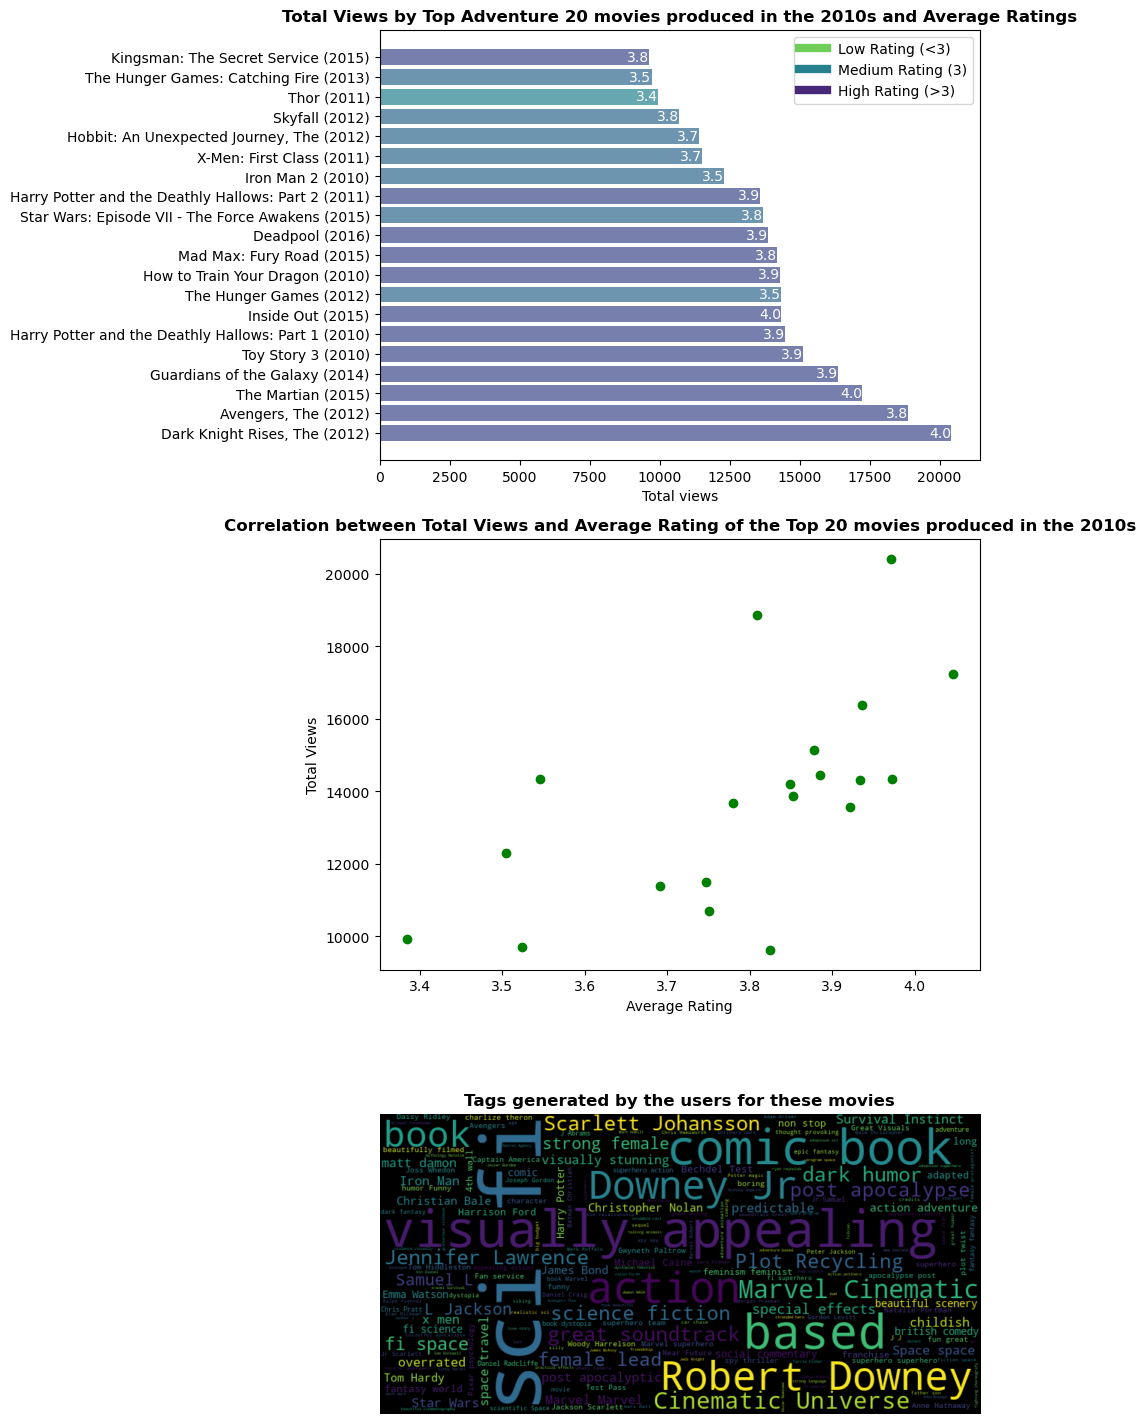

In [143]:
queried_movies, aggregate_df = find_closest_match("Adventure", 2017, dataset)

In [144]:
aggregate_df

,movieId,title,genres,movie_year,total_views,average_rating,tags
0,73321,"Book of Eli, The (2010)","[Action, Adventure, Drama]",2010.0,6248,3.463188,"[beautiful scenery, Bible, blindness, cannibal..."
1,74530,Percy Jackson & the Olympians: The Lightning T...,"[Adventure, Fantasy]",2010.0,2063,2.945710,"[Hollywood, bad acting, fantasy, childish, fra..."
2,74789,Alice in Wonderland (2010),"[Adventure, Fantasy, IMAX]",2010.0,7481,3.150648,"[Johnny Depp, Tim Burton, Stephen Fry, 3D, 3D,..."
3,76093,How to Train Your Dragon (2010),"[Adventure, Animation, Children, Fantasy, IMAX]",2010.0,14311,3.933792,"[cute, dragons, 3D, animation, cute, depth of ..."
4,76175,Clash of the Titans (2010),"[Action, Adventure, Drama, Fantasy]",2010.0,2643,2.727204,"[Greek mythology, Liam Neeson, predictable, 3D..."
...,...,...,...,...,...,...,...
939,193743,Sunshine Girl and The Hunt For Black Eyed Kids...,"[Adventure, Horror, Thriller]",2012.0,1,1.000000,[]
940,193777,Almost Home (2014),"[Adventure, Animation, Sci-Fi]",2014.0,1,2.000000,[]
941,193799,Lupin the Third: Daisuke Jigen's Gravestone (2...,"[Action, Adventure, Animation, Comedy]",2014.0,2,4.500000,[]
942,193853,Wu Kong (2017),"[Action, Adventure, Fantasy]",2017.0,1,2.000000,[]


## General insights - Useful for the studio that produces movies.

1. Views over time per Genre

In [163]:
# define the time interval for the filtered dataset
start_date= datetime(2000,12,1)
end_date= datetime(2001,2,1)
filtered_dataset = filter_time_interval(dataset, start_date, end_date)   

# explode genres columns to have one single genre per row                                              
filtered_dataset_exploded =  filtered_dataset.explode("genres")

# aggregate to get views over time per genre
views_over_time_by_genre = filtered_dataset_exploded.groupby(["datetime_rating", "genres"]).size()
views_over_time_by_genre = views_over_time_by_genre.reset_index().rename(columns={0: "views"})

#pivot df
views_over_time_by_genre_pivoted = views_over_time_by_genre.pivot(index="datetime_rating", columns="genres", values="views")

In [164]:
#aggregate number of total views per hour
agg_views_over_time = views_over_time_by_genre_pivoted.resample("H").count()

# agg_views_over_time[agg_views_over_time.Drama > 1000]

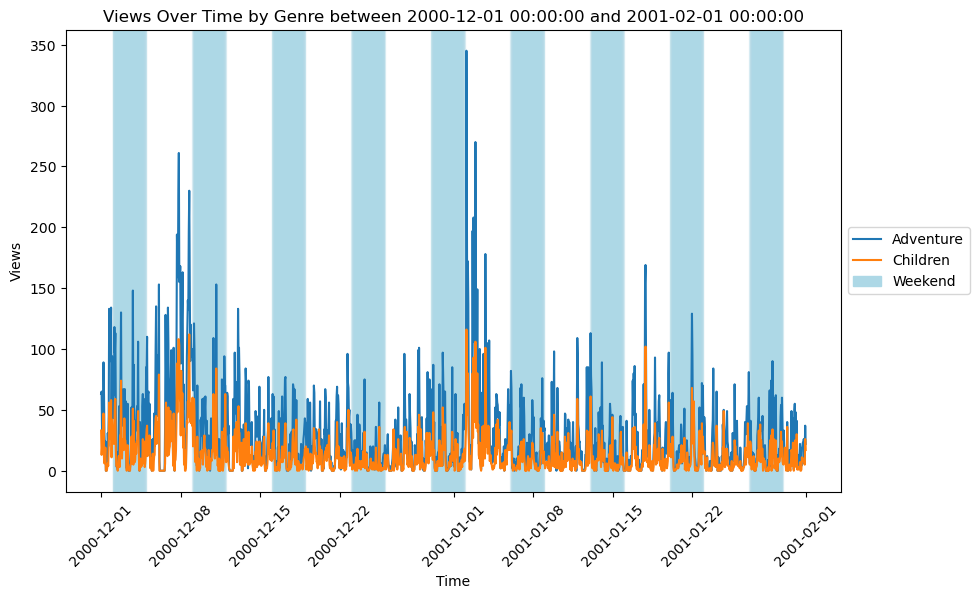

In [165]:
# Select one of the two genres_list below:
# if all genres want to be visualized, uncomment the first genres_list variable.
# if specific genres want to be visulaized, uncomment and add genres to the second genres_list variable.
# genres_list = agg_views_over_time.columns
genres_list = ["Adventure", "Children"]

# Create a line plot of views over time with different lines for each genre
plt.figure(figsize=(10, 6))
for genre in genres_list:
    plt.plot(agg_views_over_time[genre], label=genre)

plt.ylabel("Views")
plt.xlabel("Time")
plt.title(f"Views Over Time per Genre between {start_date} and {end_date}")
plt.xticks(rotation=45)

weekends = agg_views_over_time.index[agg_views_over_time.index.weekday >= 5]
for weekend in weekends:
    plt.axvspan(weekend, weekend + pd.Timedelta(days=1), color='lightblue', alpha=0.3)

handles, labels = plt.gca().get_legend_handles_labels()

patch = mpatches.Patch(color='lightblue', label='Weekend')   

handles.extend([patch])

plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

2. Most watched movies

In [145]:
aggregate_df = aggregate_data(dataset)

most_watched_movies_df = aggregate_df.sort_values(by="total_views", ascending=False)

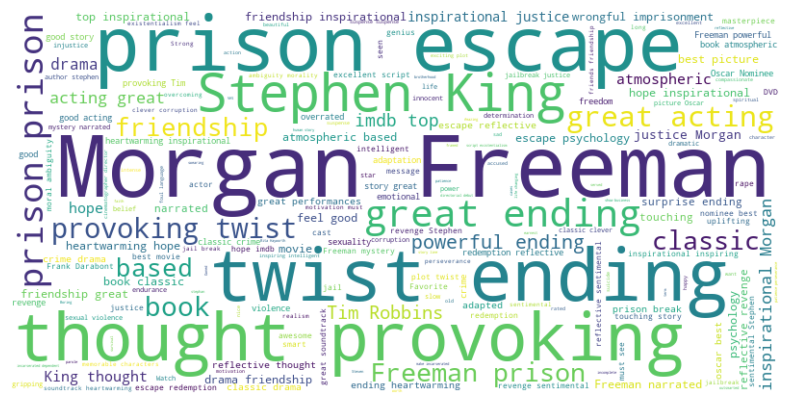

In [151]:
tags_best_movie = most_watched_movies_df.tags.iloc[0]

# Convert the list of tags to a string
tags_str = ' '.join(tags_best_movie)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tags_str)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

3. Which genre is the most watched one?

In [152]:
top_genres = most_watched_movies_df.copy()

top_genres = top_genres.explode("genres")

top_genres = pd.DataFrame(top_genres.groupby("genres")["movieId"].count()).rename(columns={"movieId": "views"}).sort_values(by="views", ascending=False)

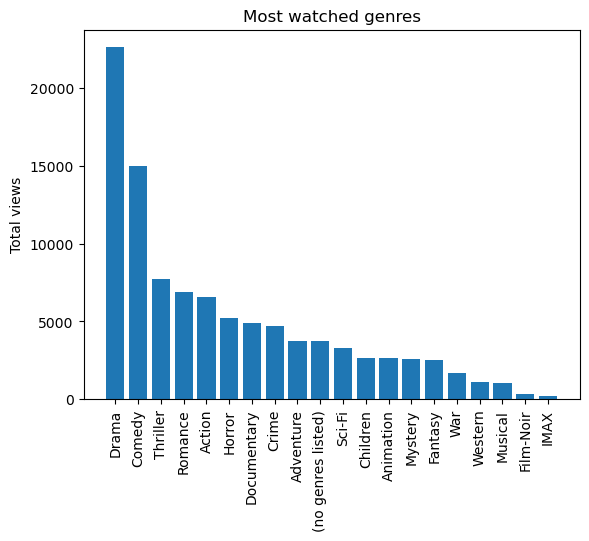

In [153]:
# generate visualization
plt.bar(top_genres.index, top_genres.views)
plt.xticks(rotation = 90)
plt.title("Most watched genres")
plt.ylabel("Total views")
plt.show()

4. Movie Saga analysis

In [213]:
# use this insight to check how many views a sequel/saga movie hit w.r.t. the original movie.
# as an example, the Star Wars saga has been checked.
movie_saga_title = "Star Wars: Episode"

sequels_df = dataset[dataset["title"].str.contains(movie_saga_title)].sort_values(by="movie_year")

sequels_df

,userId,movieId,rating,timestamp_rating,tag,timestamp_tag,title,genres,datetime_rating,datetime_tag,movie_year
21,206877,260,5.0,854979058,NaN,NaN,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",1997-02-03 14:10:58,NaT,1977.0
13551420,143685,260,4.0,1361087669,NaN,NaN,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",2013-02-17 07:54:29,NaT,1977.0
13551323,270442,260,3.5,1195740921,NaN,NaN,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",2007-11-22 14:15:21,NaT,1977.0
13551310,39567,260,4.0,971448896,NaN,NaN,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",2000-10-13 14:54:56,NaT,1977.0
13550374,193983,260,5.0,962638725,NaN,NaN,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",2000-07-03 15:38:45,NaT,1977.0
...,...,...,...,...,...,...,...,...,...,...,...
15619919,195813,122886,4.5,1471707474,NaN,NaN,Star Wars: Episode VII - The Force Awakens (2015),"[Action, Adventure, Fantasy, Sci-Fi, IMAX]",2016-08-20 15:37:54,NaT,2015.0
7995224,138420,122886,3.5,1474750565,NaN,NaN,Star Wars: Episode VII - The Force Awakens (2015),"[Action, Adventure, Fantasy, Sci-Fi, IMAX]",2016-09-24 20:56:05,NaT,2015.0
1293427,234076,122886,4.0,1485374196,NaN,NaN,Star Wars: Episode VII - The Force Awakens (2015),"[Action, Adventure, Fantasy, Sci-Fi, IMAX]",2017-01-25 19:56:36,NaT,2015.0
7997383,240100,122886,3.5,1461652797,NaN,NaN,Star Wars: Episode VII - The Force Awakens (2015),"[Action, Adventure, Fantasy, Sci-Fi, IMAX]",2016-04-26 06:39:57,NaT,2015.0


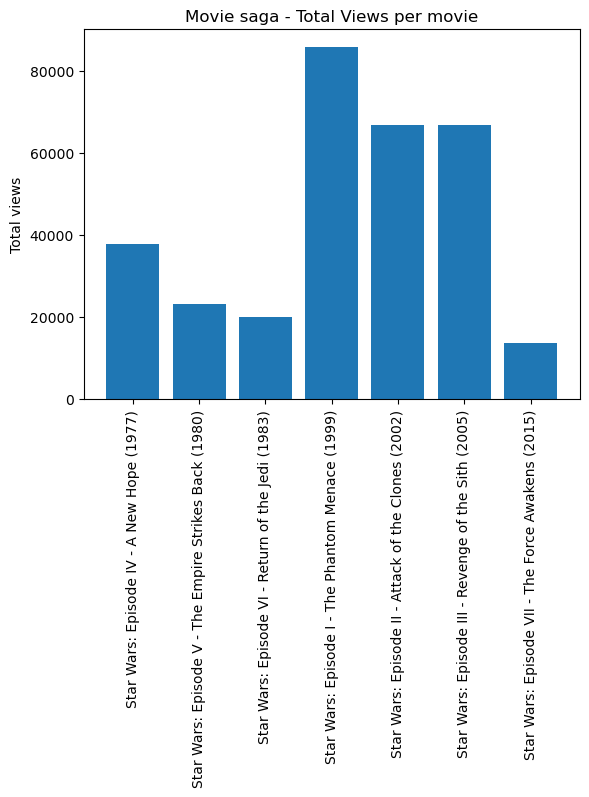

In [216]:
# visualize data
plt.bar(sequels_df.title.unique(), sequels_df.groupby(["title"])["movieId"].count())
plt.xticks(rotation=90)
plt.ylabel("Total views")
plt.title("Movie saga - Total Views per movie")

plt.show()
